<a href="https://colab.research.google.com/github/itznotpk/SSSVC2025_SWDD-Pole_WildGuard-Sentinel/blob/main/v8_Figure2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Choose T4 GPU Runtime Type -> connect

Verify NVIDIA GPU Availability

In [ ]:
!nvidia-smi

Sat Sep  6 03:17:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

1. Gather & Label Training Images

Label Studio: project.zip file
1.   imges
2.   labels
3.   classses.txt
4.   notes.json

Roboflow: API

2. Upload Image Dataset and Prepare Training Data (data.zip file)

If use google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp /content/gdrive/MyDrive/path/to/data.zip /content

Roboflow

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="hzKCObpe1myu8g36zdvo")
project = rf.workspace("swdd-pole-elephant-figure").project("my-first-project-gm307")
version = project.version(1)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 86.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to My-First-Project-1 in yolov8:: 100%|██████████| 1740/1740 [00:00<00:00, 9714.34it/s]


Sample Datasets

In [ ]:
# To use my one of pre-made dataset instead of your own custom dataset, download it here (control which dataset is downloaded by commenting out either line)
!wget -O /content/data.zip https://s3.us-west-1.amazonaws.com/evanjuras.com/resources/candy_data_06JAN25.zip # Candy dataset
#!wget -O /content/data.zip https://s3.us-west-1.amazonaws.com/evanjuras.com/resources/YOLO_coin_data_12DEC30.zip # Coin dataset

2.1 Split Images into train & validation folders

In [ ]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

Ultralytics requires a particular folder structure to store training data for models. The root folder is named “**data**”. Inside, there are two main folders:

**Train**: Actual images used to train the model. In one epoch of training, every image in the train set is passed into the neural network. The training algorithm adjusts the network weights to fit the data in the images.

**Validation**: Images for checking model's performance at the end of each training epoch.

In each of these folders is a “**images**” folder and a “**labels**” folder, which hold the image files and annotation files respectively.

Create required folder structure & randomly move 90% of dataset to the "train" folder and 10% to the "validation" folder:

In [ ]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

--2025-09-06 03:20:31--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-09-06 03:20:31 (63.2 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 360
Number of annotation files: 360
Images moving to train: 324
Images moving to validation: 36


3. Install Requirements (Ultralytics)

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.3 MB/s eta 0:00:00


4. Configure Training

Generate a data.yaml configuration file. Make sure there is a labelmap file located at custom_data/classes.txt.

In [ ]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 2
names:
- Elephas Maximus
- KK Cattle


5. Train Model

Options: yolo11n.pt, yolo11s.pt, yolo11m.pt, yolo11l.pt, and yolo11xl.pt.

Larger models run slower but have higher accuracy, while smaller models run faster but have lower accuracy.

If you aren't sure which model size to use, yolo11s.pt is a good starting point.

Normally: yolo11 yolov8 yolov5

Number of epochs (epochs)

One “epoch” is one single pass through the full training dataset.
*   < 200 images: 60 epochs
*   more than 200 images: 40 epochs


Resolution (imgsz)

Resolution has a large impact on the speed and accuracy of the model: a lower resolution model will have higher speed but less accuracy.

YOLO models are typically trained and inferenced at a 640x640 resolution.

Faster: lower resolution like 480x480.

In [ ]:
!yolo detect train data=/content/data.yaml model=yolov8s.pt epochs=80 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.194 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_widt

The best trained model weights will be saved in content/runs/detect/train/weights/best.pt.

Additional information about training is saved in the content/runs/detect/train folder, including a results.png file that shows how loss, precision, recall, and mAP progressed over each epoch.

6. Test Model

Run the model on the images in the validation folder and then display the results for the first 10 images.

In [ ]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.194 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs

image 1/36 /content/data/validation/images/063503e1-Pics_96.jpg: 384x640 1 Elephas Maximus, 46.5ms
image 2/36 /content/data/validation/images/07e4c8f3-Pics_191.jpg: 384x640 2 Elephas Maximuss, 10.7ms
image 3/36 /content/data/validation/images/0bb9beac-Pics_38.jpg: 384x640 1 Elephas Maximus, 10.6ms
image 4/36 /content/data/validation/images/10688782-Pics_63.jpg: 384x640 1 Elephas Maximus, 10.6ms
image 5/36 /content/data/validation/images/169de1e3-Pics_61.jpg: 384x640 1 Elephas Maximus, 10.6ms
image 6/36 /content/data/validation/images/20789026-Pics_137.jpg: 384x640 1 Elephas Maximus, 1 KK Cattle, 10.6ms
image 7/36 /content/data/validation/images/232ac6db-Pics_111.jpg: 384x640 1 KK Cattle, 10.6ms
image 8/36 /content/data/validation/images/286ac725-Pics_118.jpg: 384x640 1 KK Cattle, 10.6ms
image 9/36 /content/data/validation/

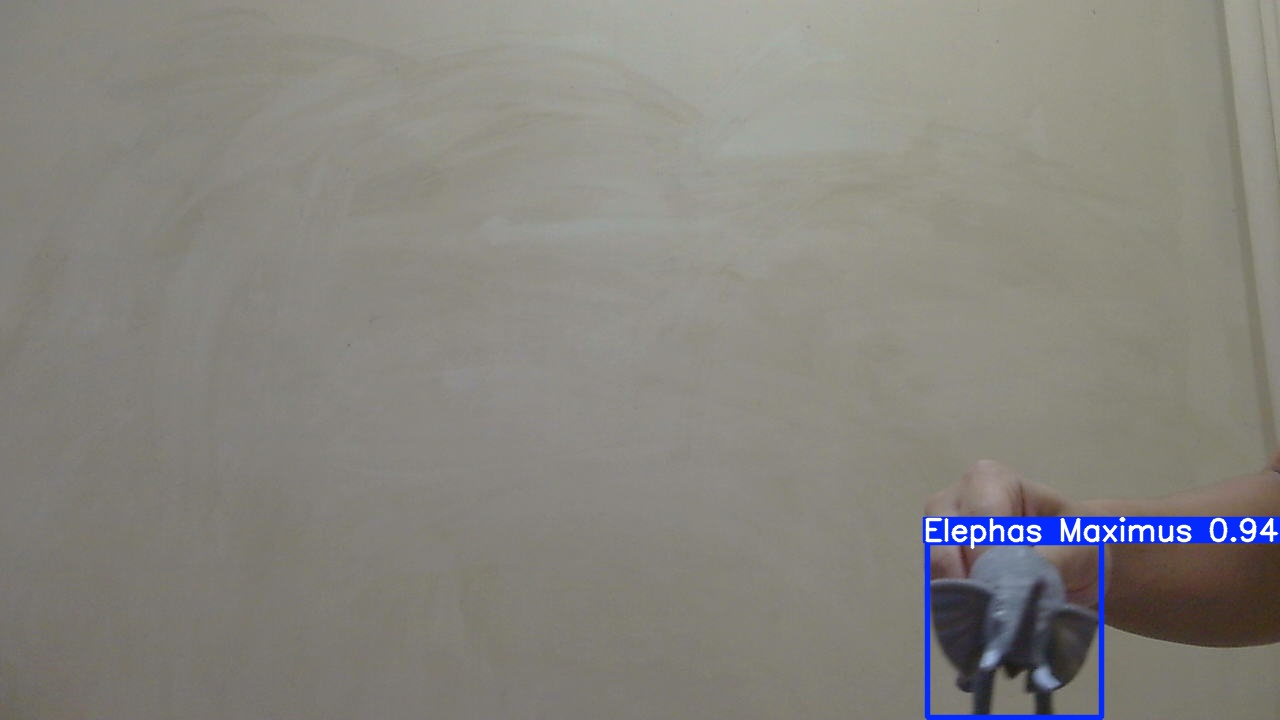

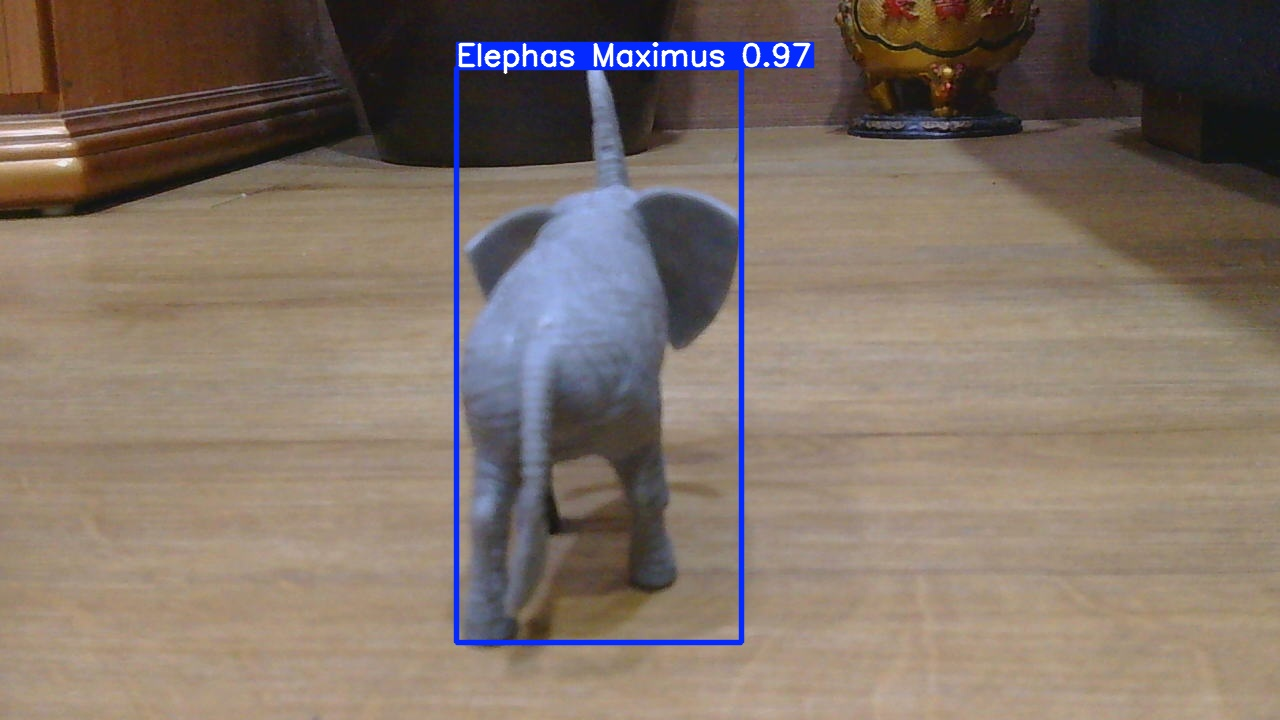

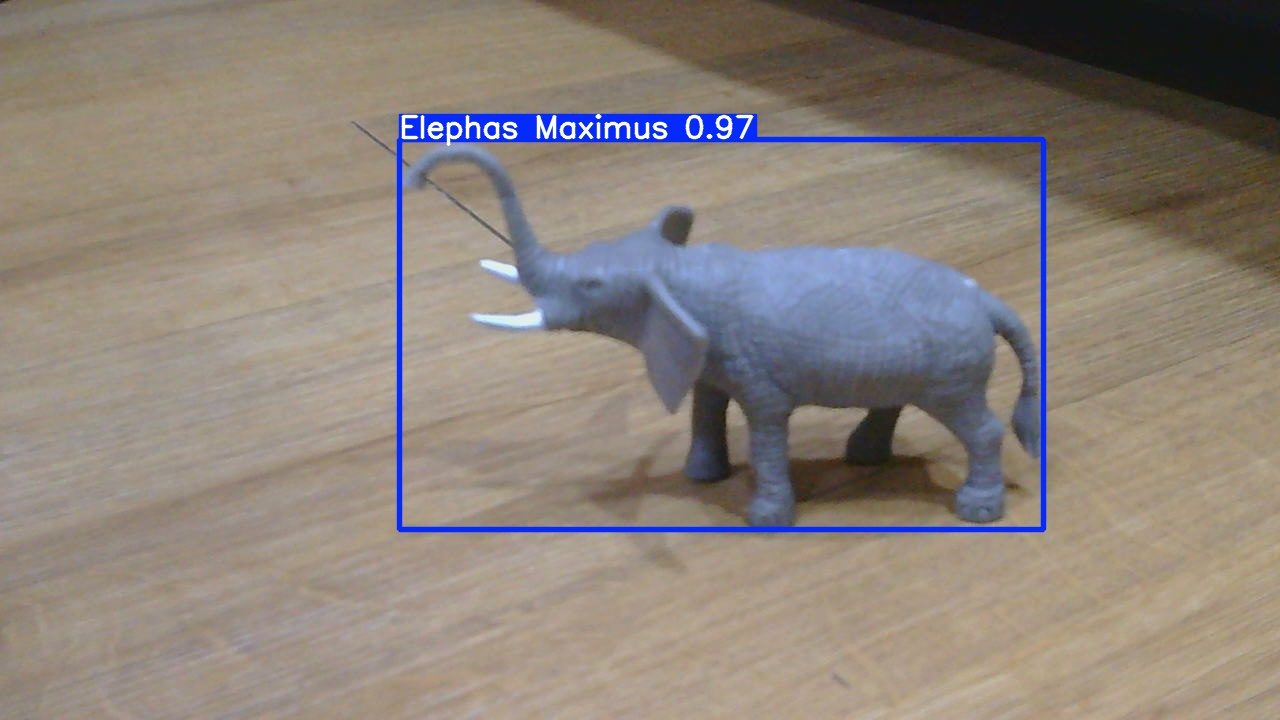

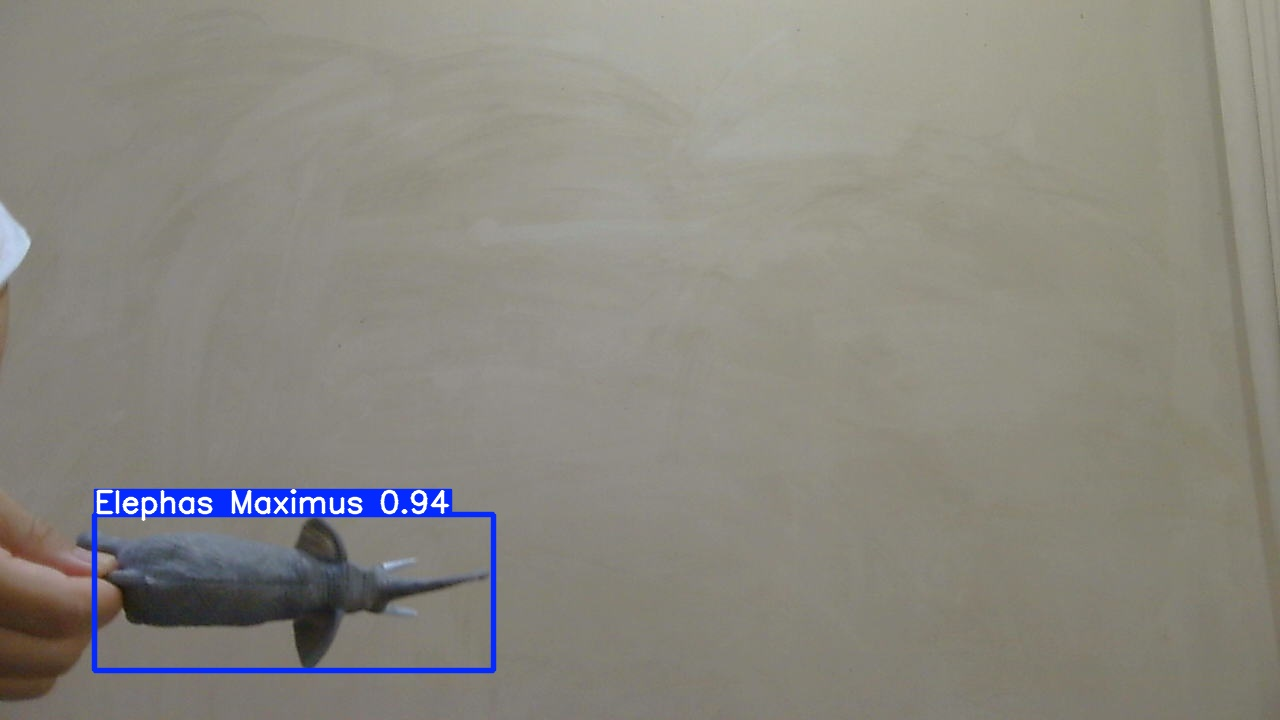

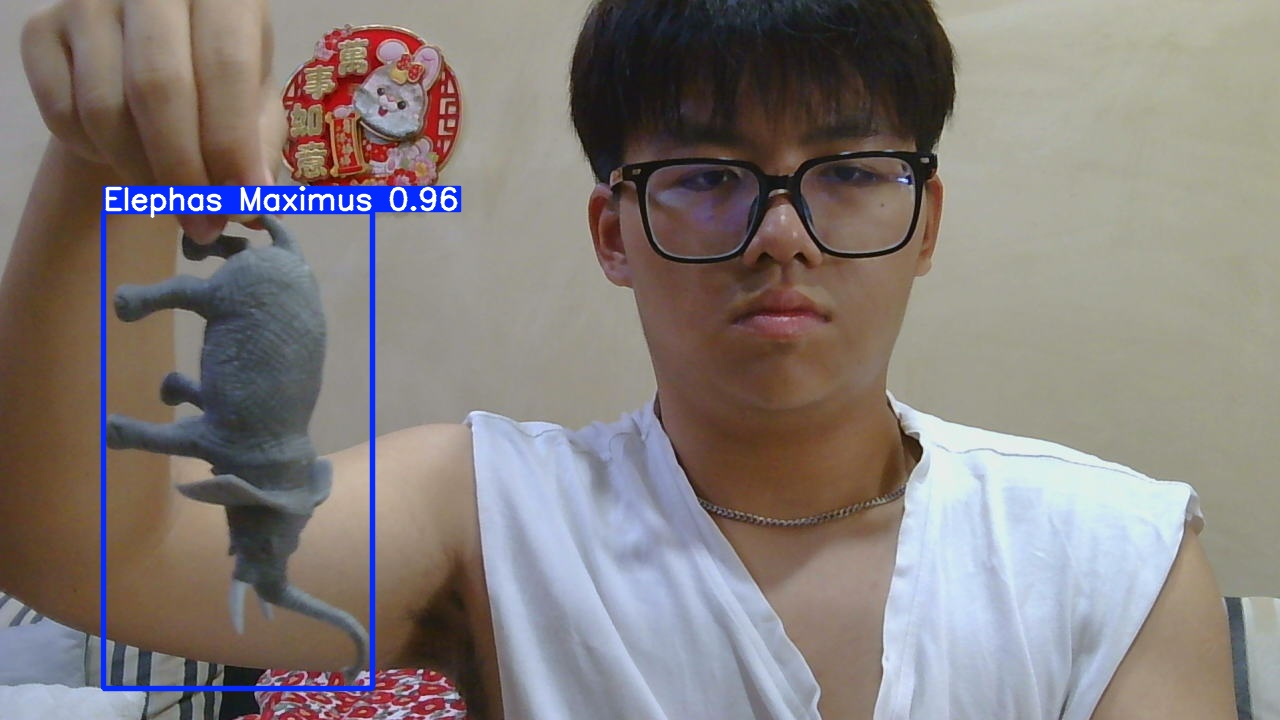

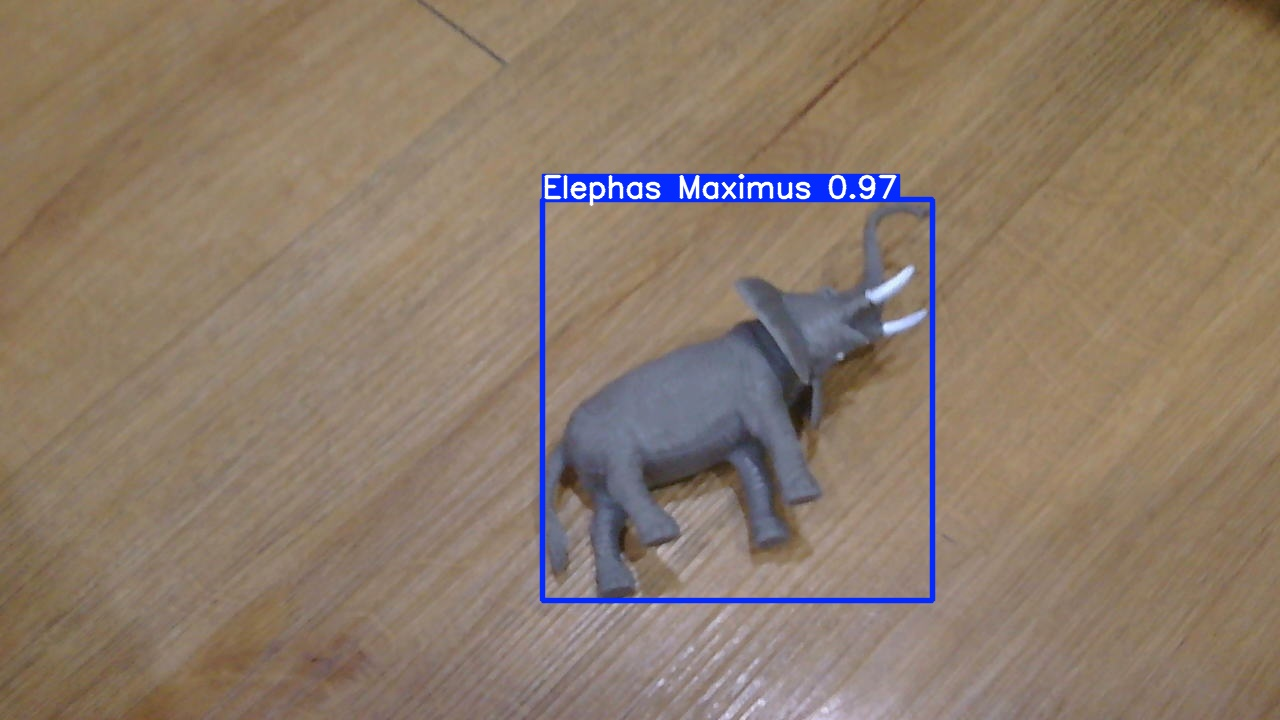

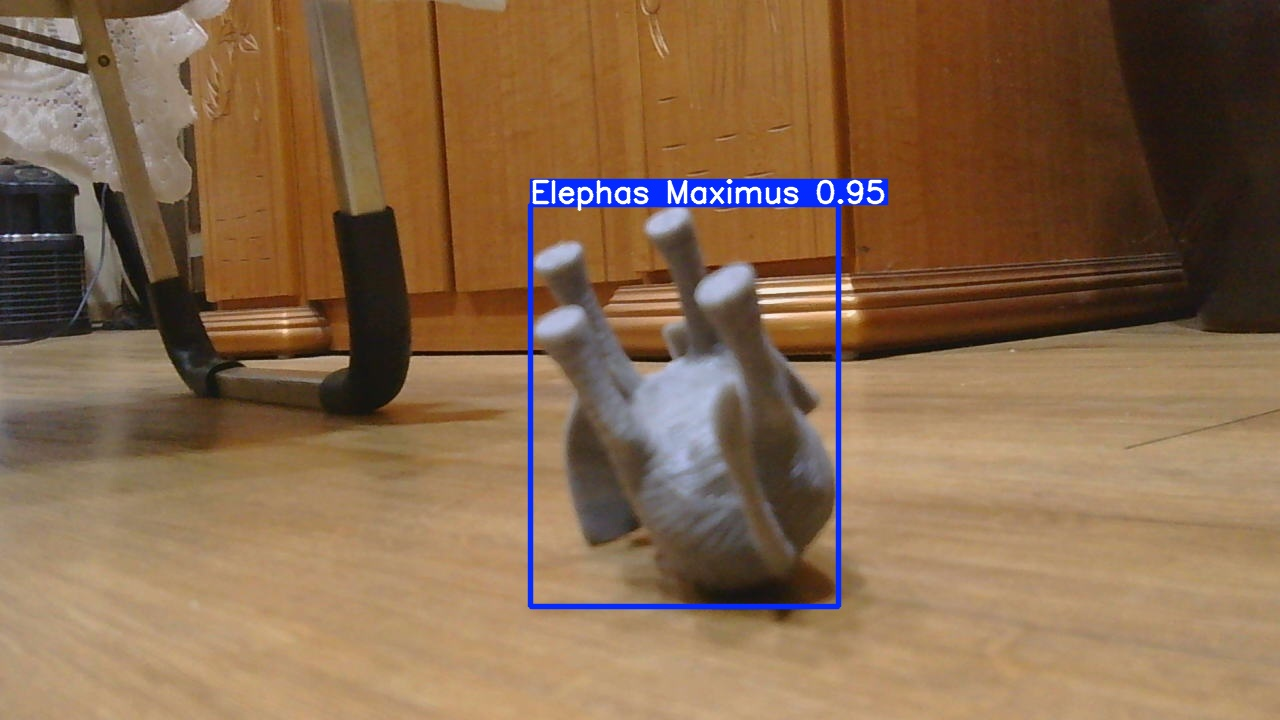

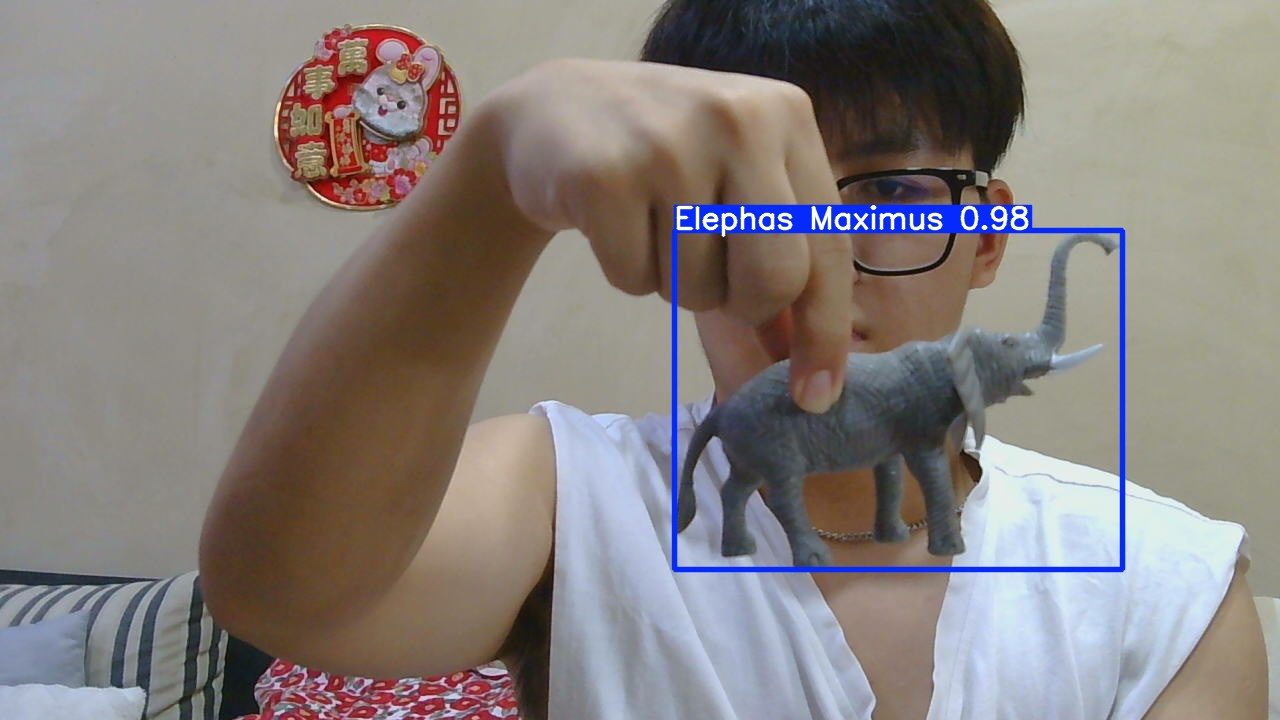

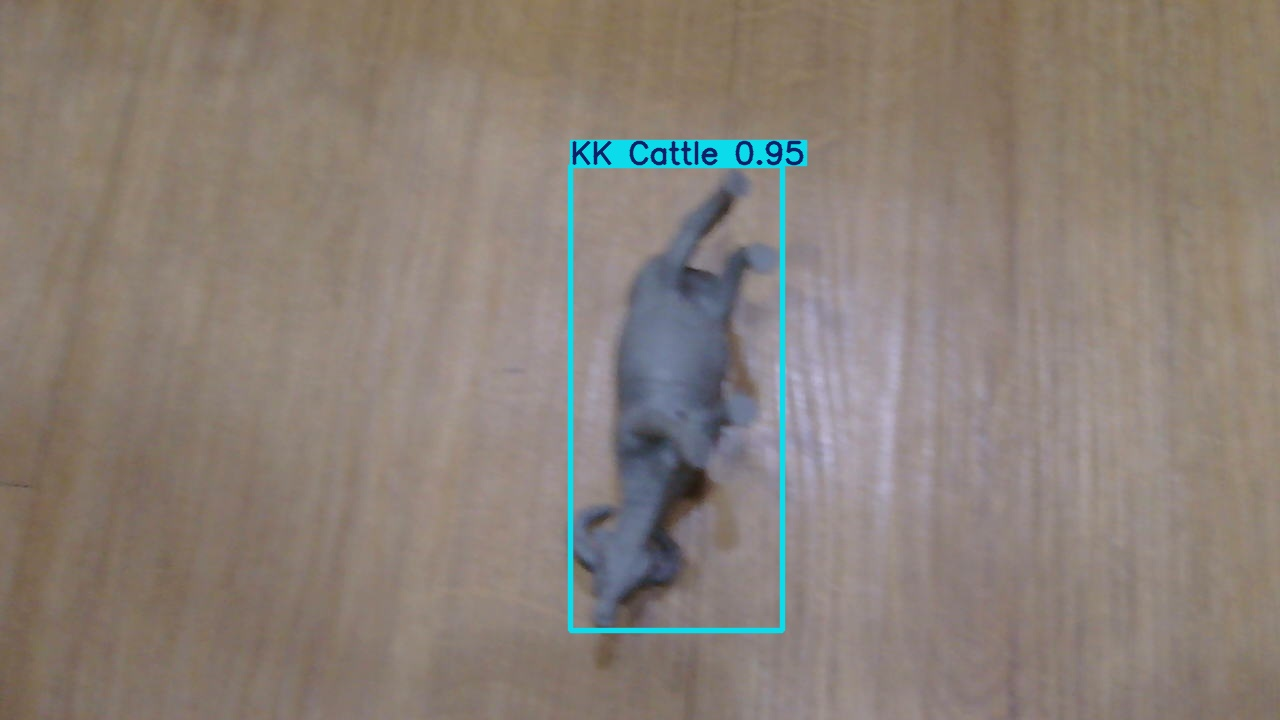

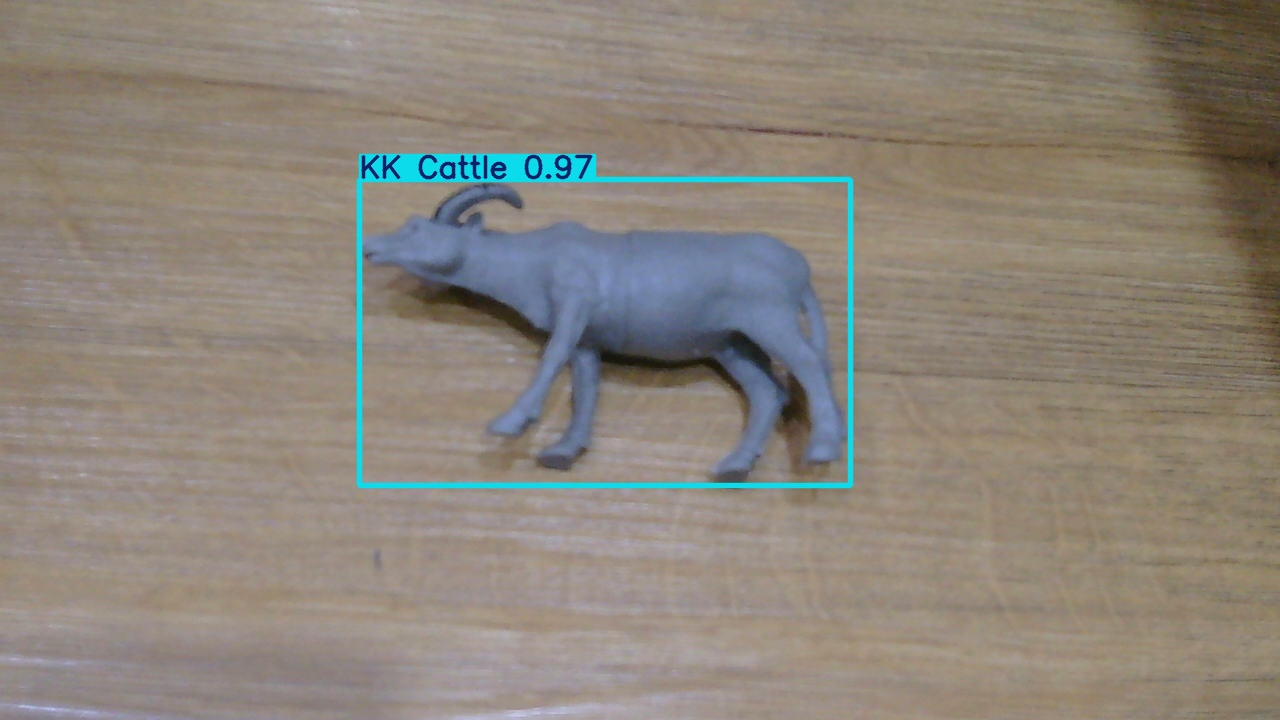

In [ ]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


7 Download YOLO Model

The code creates a folder named my_model, moves the model weights into it, and renames them from best.pt to my_model.pt.

It also adds the training results in case you want to reference them later. It then zips the folder as my_model.zip.

In [ ]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

/content/my_model
  adding: my_model.pt (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/train_batch1472.jpg (deflated 20%)
  adding: train/val_batch0_pred.jpg (deflated 9%)
  adding: train/train_batch1471.jpg (deflated 17%)
  adding: train/args.yaml (deflated 53%)
  adding: train/confusion_matrix.png (deflated 34%)
  adding: train/val_batch1_pred.jpg (deflated 11%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/best.pt (deflated 8%)
  adding: train/weights/last.pt (deflated 8%)
  adding: train/results.png (deflated 8%)
  adding: train/train_batch1470.jpg (deflated 14%)
  adding: train/val_batch1_labels.jpg (deflated 11%)
  adding: train/BoxR_curve.png (deflated 18%)
  adding: train/BoxP_curve.png (deflated 21%)
  adding: train/BoxPR_curve.png (deflated 27%)
  adding: train/train_batch2.jpg (deflated 7%)
  adding: train/val_batch0_labels.jpg (deflated 10%)
  adding: train/results.csv (deflated 63%)
  adding: train/confusion_matrix_normalized.png (deflated 32%)
 

In [ ]:
# This takes forever for some reason, you can also just download the model from the sidebar
from google.colab import files

files.download('/content/my_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

8.0 Deploy YOLO Model

yolo_detect.py: https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/blob/daabb56e65ab3090fe046f761ed035157a0d9350/yolo_detect.py

8.1 Download & Install Anaconda Prompt



> https://www.google.com/url?q=https%3A%2F%2Fanaconda.com%2Fdownload



8.2 Set Up Virtual Environment



> conda create --name yolo-env1 python=3.12


> conda activate yolo-env1





8.3 Install Ultralytics



> pip install ultralytics



8.3 If you have an NVIDIA GPU, you can install the GPU-enabled version of PyTorch by issuing the following command in Anaconda Prompt:



> pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124




8.4 Extract downloaded model
Take the my_model.zip file you downloaded and unzip it to a folder on your PC.

In the Anaconda Prompt terminal, move into the unzipped folder using:



> cd path/to/folder



8.5 Download yolo_detect.py into my_model folder using:



> curl -o yolo_detect.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/yolo_detect.py



8.6 Run thw script



> python yolo_detect.py --model my_model.pt --source usb0 --resolution 1280x720



Reference:

> https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/blob/daabb56e65ab3090fe046f761ed035157a0d9350/README.md

